Naive method: 293ms
K-D tree: 0ms


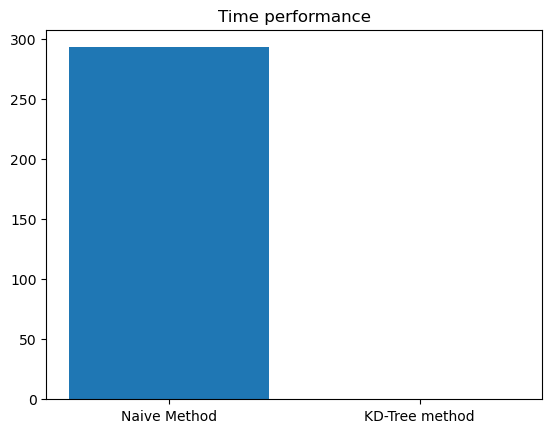

In [1]:
from typing import List
from collections import namedtuple
import time
import matplotlib.pyplot as plt        # plotting lib


"""
Explanation:
Define a class named Point, which is a child class of the builtin class namedtuple.
Point has 2 properties: x and y
And set its pattern when printed.
"""
class Point(namedtuple("Point", "x y")):
    def __repr__(self) -> str:
        return f'Point{tuple(self)!r}'

    
"""
Explanation:
Define a class named Rectangle, which is also a child class of the builtin class namedtuple.
Rectangle has 2 properties: lower and upper
__repr__ sets its pattern when printed.
is_contains verifies whether a Point instance is within the region of the Rectangle instance.

"""
class Rectangle(namedtuple("Rectangle", "lower upper")):
    def __repr__(self) -> str:
        return f'Rectangle{tuple(self)!r}'

    def is_contains(self, p: Point) -> bool:
        # should between bottom-left and upper-right
        return self.lower.x <= p.x <= self.upper.x and self.lower.y <= p.y <= self.upper.y  
    
    """
    # a helper function, judging whether an area intersects with the given rectangle (not used)
    def intersect(self,area):
        x1min,y1min,x1max,y1max = area
        x2min,x2max,y2min,y2max = self.lower.x,self.lower.y,self.upper.x,self.upper.y
        if (x1max < x2min or x2max < x1min or y1max < y2min or y2max < y1min):
            return False
        return True
    """

    
"""
Explanation:
Define a class named Node, which is a child class of the builtin class namedtuple.
Node has 3 properties: location(x and y coordinates), left(left-child) and right(right-child)
And set its pattern when printed.
"""
class Node(namedtuple("Node", "location left right")):
    """
    location: Point
    left: Node
    right: Node
    """
    

    def __repr__(self):
        return f'{tuple(self)!r}'


"""
Explanation:
Define a class named KDTree
It has two functions (insert and range).
"""
class KDTree:
    """k-d tree"""

    # initialize the data structure
    def __init__(self):
        self._root = None   # property 1: root node of the tree
        self._n = 0         # property 2: number of nodes  (not called in following code)
        
        

    def insert(self, p: List[Point]):
        """insert a list of points"""
        if len(p)==0:return  # if no point, the tree is null
        k=len(p[0])   # dimension of data: k
        d=0  # current dimension, starting at 0
        
        # use recursion to build a tree 
        def buildtree(pts,d):
            """
            This function builds a kd-tree, whose root is the median of pts by the d-th dimension.
            pts: List[Point], points to separate
            d: int, the current dimension
            return: root of the kd-tree 
            """
            if len(pts)==0:return None   # no point to split
            
            pts.sort(key=lambda x:x[d])   # sort the points by current dimension
            mid=len(pts)//2   # get the index of median
            median=pts[mid]   # get the median; if the number of points is even, choose the latter one as median
            nextd=(d+1)%k  # next dimension, as a kd-tree divides the points by alternating dimensions
            
            # node.left=buildtree(pts[:mid],nextd)  
            # leftchild is a subtree consisting of the points smaller than the median
            # node.right=buildtree(pts[:mid],nextd)  
            # rightchild is a subtree consisting of the points larger than the median
            node=Node(pts[mid],buildtree(pts[:mid],nextd),buildtree(pts[mid+1:],nextd)) # create a new tree node
            self._n+=1  # the number of nodes increases by 1
               
            return node  # return root of the built tree
        
        self._root=buildtree(p,0)   # set root of the entire tree, which consisting of all given points
        
        
    
    def range(self, rectangle: Rectangle) -> List[Point]:
        """range query"""
        
        if self._root is None: return [] # if no point to search 

        # use recursion to find the answer
        def findwithin(root,dimension):
            """
            root: root node of the current subtree
            dimension: the current split dimension
            return: List[Point], the points within the rectangle
            
            Time complexity:
            In this problem, we need to consider at most two areas split by each kd-tree node, 
            and it takes constant time to verify each treenode.
            So the recurrence is :T(n)=2T(n/4)+O(1).
            According to the Master Theorem, T(n)=O(n^0.5)
            
            """
            
            if root is None: return []  # if the root is null, no points within the rectangle
            
            # if the node is a leaf, verify whether it lies inside the rectangle
            if root.left is None and root.right is None:
                # the leaf is inside the rectangle, return the single point
                if rectangle.is_contains(root.location):
                    return [root.location]
                # otherwise, no point 
                else:
                    return []
            
           
            # if the node is not a leaf
            res=[]  # points within the given rectangle
            # check whether the node itself is inside the rectangle
            if rectangle.is_contains(root.location):
                res.append(root.location)
                
            if dimension=="x":
                # if the node is to the left of the given rectangle, only consider its right-child subtree
                if root.location.x<rectangle.lower.x:
                    res+=findwithin(root.right,"y")   # the dimension alternates
                # if the node is to the right of the given rectangle, only consider its left-child subtree
                elif root.location.x>rectangle.upper.x:
                    res+=findwithin(root.left,"y")
                # the node is between the rectangle, then both children should be considered
                else:
                    res+=findwithin(root.left,"y")
                    res+=findwithin(root.right,"y") 
            else:
                # if the node is under the given rectangle, only consider its right-child subtree
                if root.location.y<rectangle.lower.y:
                    res+=findwithin(root.right,"x")   # the dimension alternates
                # if the node is over the given rectangle, only consider its left-child subtree
                elif root.location.y>rectangle.upper.y:
                    res+=findwithin(root.left,"x")
                # the node is between the rectangle, then both children should be considered
                else:
                    res+=findwithin(root.left,"x")
                    res+=findwithin(root.right,"x")
                
            return res
        
        # the kd-tree is built with "x" as its first splitting dimension
        return findwithin(self._root,"x")
    
    # find the nearest point in the tree from the given point
    def nearestneighbor(self,point:Point)-> Point:
        k=len(point)  # the number of dimensions
        
        if self._root is None:
            return None
        
        root=self._root  
        self.mindis=float("inf")  # shortest distance
        self.nearest=None  # the nearest point
        
        # helper function
        def distance(point1,point2):
            return ((point2.x-point1.x)**2+(point2.y-point1.y)**2)**0.5
        
        # use recursion to find the leaf node
        def find_nearest(node,d):
            if node is None:
                return
            
            # find the leaf node
            if node.left or node.right:
                nextd=(d+1)%k
                if node.left and point[d]<node.location[d] and node.left:
                    find_nearest(node.left,nextd)
                else:
                    find_nearest(node.right,nextd)
            
            # backtrack
            dis=distance(node.location,point)
            if dis<self.mindis:
                self.mindis=dis
                self.nearest=node.location
            
            # if the circle overlaps with the other side
            if abs(point[d]-node.location[d])<self.mindis:
                nextd=(d+1)%k
                # search in the other side
                if node.left and point[d] >= node.location[d]:
                    find_nearest(node.left, nextd)
                elif node.right and point[d] < node.location[d]:
                    find_nearest(node.right, nextd)
            
        find_nearest(root,0)     # starting dimension is "x", whose index is 0
        return self.nearest
        
def nearestneighbor_test():
    points = [Point(7, 2), Point(5, 4), Point(9, 6), Point(4, 7), Point(8, 1), Point(2, 3)]  # a point set
    kd = KDTree()    # create a new kd-tree
    kd.insert(points)    # complete the kd-tree by inserting the points
    result1 = kd.nearestneighbor(Point(5, 3))   # find the points within the rectangle in the tree
    assert result1 == Point(5, 4)   # correct answer is (5,4)
    result2 = kd.nearestneighbor(Point(4, 4.5))   
    assert result2 == Point(5, 4)   # correct answer is (5,4)
    result3 = kd.nearestneighbor(Point(20,20))   
    assert result3 == Point(9, 6)   # correct answer is (9,6)
            
        

"""
A test of kd-tree functions.
Given a set of points [Point(7, 2), Point(5, 4), Point(9, 6), Point(4, 7), Point(8, 1), Point(2, 3)], 
build a kd-tree consisting of the points in the set, and get the points within the rectangle.
The correct answer is that the points within the rectangle are (2,3) and (5,4).

"""
def range_test():
    points = [Point(7, 2), Point(5, 4), Point(9, 6), Point(4, 7), Point(8, 1), Point(2, 3)]  # a point set
    kd = KDTree()    # create a new kd-tree
    kd.insert(points)    # complete the kd-tree by inserting the points
    result = kd.range(Rectangle(Point(0, 0), Point(6, 6)))   # find the points within the rectangle in the tree
    
    assert sorted(result) == sorted([Point(2, 3), Point(5, 4)])   # correct answer is (2,3) and (5,4)


"""
A comparison between the running time of kd-tree method and naive method 

"""
def performance_test():
    
    # A set consisting of 1000*1000 points is given. 
    # The coordinates are (0,0),(0,1),(0,2)...(0,999),(1,0),(1,1)...(1,999),(2,0)...(999,0),(999,1),,...(999,999)
    points = [Point(x, y) for x in range(1000) for y in range(1000)]

    # Create a Rectangle instance, whose bottom-left is (500,500) and upper-right is (504,504)
    lower = Point(500, 500)
    upper = Point(504, 504)
    rectangle = Rectangle(lower, upper)
    
    #  naive method
    start = int(round(time.time() * 1000))    # the starting time
    # find the points within the rectangle by verifying each point
    result1 = [p for p in points if rectangle.is_contains(p)]      
    end = int(round(time.time() * 1000))      # the finishing time
    print(f'Naive method: {end - start}ms')   # print the duration
    time_naive=end-start     # calculate the duration

    kd = KDTree()     # create an empty kd-tree
    kd.insert(points)   # insert the points to complete the kd-tree
    # k-d tree
    start = int(round(time.time() * 1000))   # the starting time
    result2 = kd.range(rectangle)            # find the points within the rectangle using kd-tree method
    end = int(round(time.time() * 1000))    # the finishing time
    print(f'K-D tree: {end - start}ms')     # calculate the duration
    time_kd=end-start     # calculate the duration

    assert sorted(result1) == sorted(result2)
    
    # draw a bar plot
    plt.figure()    # create a new chart
    plt.bar(["Naive Method","KD-Tree method"],[time_naive,time_kd])    # plot the time data
    plt.title("Time performance")  # set the title
    plt.show()    # display the chart
    


if __name__ == '__main__':
    nearestneighbor_test()
    range_test()
    performance_test()

From the chart, we can see that although it takes a bit time to construct the kd-tree, the time taken to search in a range by kd-tree method is much less than naive method.